# 5.이미지 분류
## 5.1 개/고양이 예를 반려동물 품종으로 확장하기

In [1]:
# load dataset
from fastai.vision.all import *
path = untar_data(URLs.PETS)

path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [2]:
(path/"images").ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_31.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_153.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_176.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_194.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_140.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_86.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_23.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_76.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_26.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_39.jpg')...]

In [3]:
# test one file
fname = (path/"images").ls()[0]
re.findall(r"(.+)_\d+.jpg$", fname.name)  # 하나 이상의 숫자와 확장자 이전의 모든 문자 

['British_Shorthair']

In [4]:
# DataBlock
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r"(.+)_\d+.jpg$"), "name"),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [5]:
# item_tfms=Resize(460)  # 전체 너비나 높이를 기준으로 잘라내는 단계
# batch_tfms=aug_transforms(size=224, min_scale=0.75)  # 임의의 부분을 잘라낸 후 증강하는 단계

## 5.2 사전 크기 조절

- 이미지 증강 결과 확인 후 기본 모델로 빠르게 테스트를 권장함

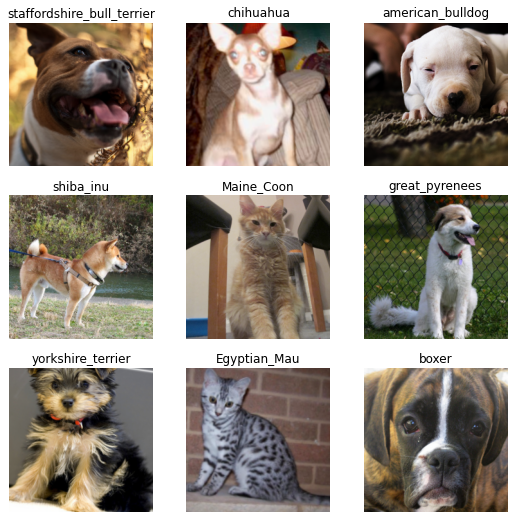

In [6]:
dls.show_batch(nrows=3, ncols=3)

In [7]:
# 이미지 크기를 조절하는 부분이 빠진 경우 등 summary를 통해서 확인 가능
# error 출력 사례
pets_error = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       splitter=RandomSplitter(seed=42),
                       get_y=using_attr(RegexLabeller(r"(.+)_\d+.jpg$"), "name"))

# pets_error.summary(path/"images")  # will raise a error

In [8]:
# 기본 모델 사용을 통한 학습 검증
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.517138,0.334330,0.108254,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.505240,0.307612,0.095399,00:26
1,0.326628,0.226914,0.073072,00:26


## 5.3 교차 엔트로피 손실

- 종속 변수에 범주가 둘 이상이더라도 작동
- 더 빠르고 안정적인 학습 결과

In [9]:
x, y = dls.one_batch()
y  # 배치 크기는 64

TensorCategory([29, 29, 23, 10, 12, 12,  6, 35, 14, 30,  1, 19, 20, 10, 32, 11, 14,  0,
        17,  6,  5,  9,  3, 16, 31, 27, 19, 21, 21, 23, 14,  9, 11, 26, 34, 13,
         8, 19,  5, 18, 35,  4, 33,  8,  4, 31, 27, 12,  6, 33, 16,  1, 15,  4,
        32, 21, 11,  9, 22, 27, 15, 29, 23,  7], device='cuda:0')

In [10]:
preds, _ = learn.get_preds(dl=[(x, y)])
preds[0]  # 예측 결과의 첫 줄만 확인

TensorBase([1.3791e-07, 1.2098e-06, 1.5059e-06, 1.6812e-07, 1.1130e-06, 5.2512e-06,
        6.5182e-08, 2.1587e-06, 1.2415e-07, 1.0464e-06, 3.1560e-06, 1.8126e-06,
        5.2750e-05, 1.1667e-07, 8.3623e-07, 1.6548e-07, 7.0474e-06, 4.3059e-07,
        8.5650e-08, 1.5176e-07, 1.0835e-07, 1.1728e-06, 9.7504e-07, 1.6356e-05,
        1.3049e-06, 2.0060e-07, 2.5984e-08, 7.6846e-07, 3.0322e-08, 9.9989e-01,
        3.1557e-07, 2.4557e-07, 3.5501e-07, 4.8778e-06, 2.5775e-07, 1.3720e-06,
        3.6259e-06])

In [11]:
len(preds[0]), preds[0].sum().item()  # 모든 클래스의 확률합은 1

(37, 1.0)

### softmax

In [12]:
acts = torch.randn((6, 2)) * 2
acts

tensor([[-0.9916, -2.2545],
        [ 0.1560, -1.9368],
        [-0.6164,  1.1047],
        [-2.0798, -2.1778],
        [ 1.6429, -3.7728],
        [-1.2445, -2.9512]])

In [13]:
acts.sigmoid()

tensor([[0.2706, 0.0950],
        [0.5389, 0.1260],
        [0.3506, 0.7511],
        [0.1111, 0.1018],
        [0.8379, 0.0225],
        [0.2237, 0.0497]])

In [14]:
(acts[:, 0] - acts[:, 1]).sigmoid()  # (1)

tensor([0.7795, 0.8902, 0.1517, 0.5245, 0.9956, 0.8464])

In [15]:
def softmax(x):
    return exp(x) / exp(x).sum(dim=1, keepdim=True)

In [16]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts   # (1)의 숫자 3일 확률과 동일

tensor([[0.7795, 0.2205],
        [0.8902, 0.1098],
        [0.1517, 0.8483],
        [0.5245, 0.4755],
        [0.9956, 0.0044],
        [0.8464, 0.1536]])

### Negative log likelihood

In [17]:
def mnist_loss(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).mean()

In [18]:
targ = tensor([0, 1, 0, 1, 1, 0])
targ

tensor([0, 1, 0, 1, 1, 0])

In [19]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.7795, 0.1098, 0.1517, 0.4755, 0.0044, 0.8464])

In [20]:
sm_acts

tensor([[0.7795, 0.2205],
        [0.8902, 0.1098],
        [0.1517, 0.8483],
        [0.5245, 0.4755],
        [0.9956, 0.0044],
        [0.8464, 0.1536]])

In [21]:
-sm_acts[idx, targ]

tensor([-0.7795, -0.1098, -0.1517, -0.4755, -0.0044, -0.8464])

In [22]:
F.nll_loss(sm_acts, targ, reduction="none")  # 위의 행위를 한 줄로 설명

tensor([-0.7795, -0.1098, -0.1517, -0.4755, -0.0044, -0.8464])

### Cross entropy loss
- log(negative log likelihood)
- 작은 수의 곱셈을 덧셈으로 변환해서 연산을 쉽게 변환
- 파이토치의 모든 손실 함수는 클래스 형식과 F 네임스페이스의 일반 함수, 2가지 방식을 제공
- 단, 클래스 형식을 선호함

In [23]:
loss_func = nn.CrossEntropyLoss()
loss_func(acts, targ)

tensor(1.7790)

In [24]:
F.cross_entropy(acts, targ)

tensor(1.7790)

In [25]:
# reduce = "none" : 평균 손실(기본값)이 아닌 개별 손실을 반환함
nn.CrossEntropyLoss(reduction="none")(acts, targ)

tensor([0.2491, 2.2091, 1.8857, 0.7434, 5.4201, 0.1667])

## 5.4 모델 해석

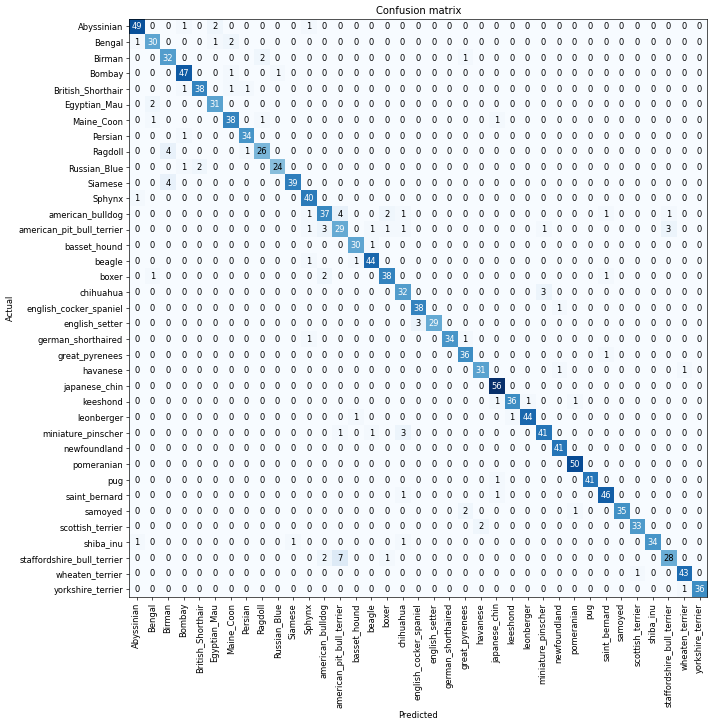

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [27]:
interp.most_confused(min_val=5)  # 가장 성능이 안좋은 상위 리스트

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 7)]

## 5.5 모델 향상하기
### 학습률 정하기
- 최소 손실이 발생한 지점보다 한 자릿수 작은 학습률
- 손실이 명확히 감소하는 마지막 지점

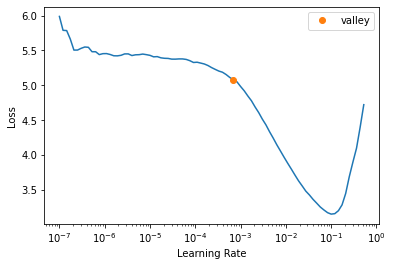

In [28]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
suggested_lr = learn.lr_find()  # log scale

In [29]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=suggested_lr.valley)

epoch,train_loss,valid_loss,error_rate,time
0,2.285448,0.458808,0.135995,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.665376,0.285204,0.094723,00:26
1,0.466936,0.241533,0.079161,00:26


### freezing and transfer learning

In [30]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      /opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py
Type:      method


In [31]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)  # 낮은 학습률로 시작 후 증가시키도, 다시 학습률을 감소시킴
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.160054,0.397689,0.123816,00:22
1,0.518860,0.235670,0.071719,00:22
2,0.326353,0.214930,0.071042,00:22


In [32]:
learn.unfreeze()  # 모델 동결 해제

SuggestedLRs(valley=9.999999747378752e-06)

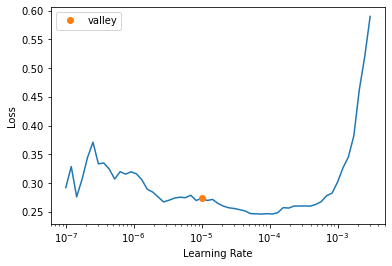

In [33]:
learn.lr_find()  # 학습률 재검색

In [34]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.260468,0.207927,0.068336,00:26
1,0.243558,0.203450,0.066982,00:26
2,0.225663,0.197405,0.061570,00:27
3,0.213775,0.195835,0.062923,00:26
4,0.196144,0.190183,0.060217,00:26
5,0.182829,0.190493,0.059540,00:26


### discriminative learning rates
- 신경망의 서로 다른 계측들은 서로 다른 속도로 학습되어야 한다는 전이 학습 개념에 기반함

In [35]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))  # 초기 계층은 1e-6, 나머지는 1e-4까지 일정하게 증가

epoch,train_loss,valid_loss,error_rate,time
0,1.131100,0.307036,0.096076,00:22
1,0.510016,0.245005,0.079838,00:21
2,0.321200,0.224844,0.075778,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.276753,0.221170,0.075778,00:26
1,0.252802,0.207979,0.068336,00:26
2,0.237031,0.211205,0.073072,00:26
3,0.221803,0.200643,0.069012,00:26
4,0.198819,0.187444,0.060893,00:26
5,0.169114,0.199674,0.065629,00:26
6,0.161260,0.186306,0.061570,00:26
7,0.146604,0.186486,0.062246,00:26
8,0.135881,0.185078,0.061570,00:26
9,0.130900,0.187474,0.061570,00:26


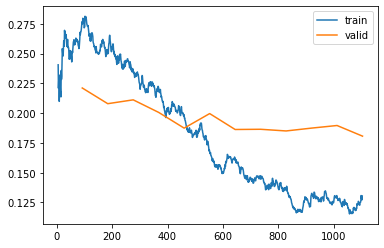

In [36]:
# check via graph
learn.recorder.plot_loss()

In [37]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.312888,0.284223,0.089310,00:36
1,0.609168,0.321721,0.100135,00:34
2,0.428445,0.275744,0.083897,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.283026,0.253525,0.078484,00:43
1,0.312901,0.396329,0.102165,00:42
2,0.232639,0.310491,0.090663,00:42
3,0.136581,0.217389,0.064276,00:43
4,0.084181,0.176967,0.056157,00:42
5,0.062711,0.169973,0.053451,00:43
